In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import  SGD
from keras.utils import np_utils
from keras import backend as K
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.


In [3]:
import pickle
import gzip
training_set = pickle.load(open("training_set.pkl","rb"))

In [4]:
sample = training_set[34]
print(sample["img"].shape,sample["class"])
sample = training_set[33]
print(sample["img"].shape,sample["class"])
sample = training_set[32]
print(sample["img"].shape,sample["class"])
sample = training_set[31]
print(sample["img"].shape,sample["class"])

(91, 92, 3) 12
(79, 94, 3) 25
(34, 34, 3) 14
(58, 58, 3) 10


In [5]:
test_set = pickle.load(open("testing_set.pkl","rb"))

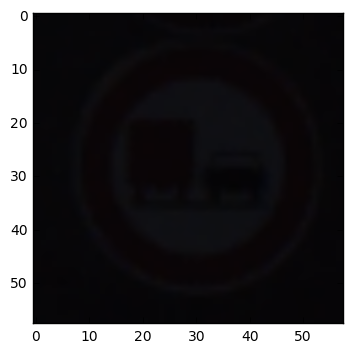

In [6]:
import matplotlib.pyplot as plt
plt.imshow(sample["img"]);
plt.show()

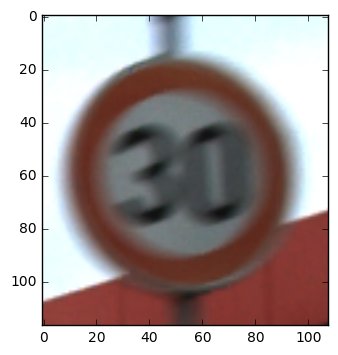

In [7]:
sample_test = test_set[1]
plt.imshow(sample_test["img"]);
plt.show()

(40, 40, 3) 1


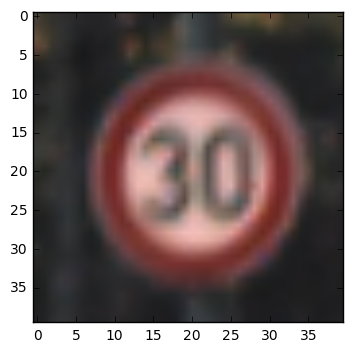

In [8]:
sample = training_set[30]
print(sample["img"].shape,sample["class"])
sample.values()
plt.imshow(sample["img"]);
plt.show()

(40, 40, 3) 1


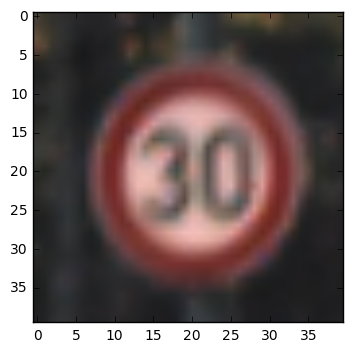

In [9]:
sample = training_set[30]
print(sample["img"].shape,sample["class"])
sample.values()
plt.imshow(sample["img"]);
plt.show()

In [10]:
len(training_set)
range(len(training_set))

range(0, 39209)

In [11]:
class_all = [training_set[x]['class'] for x in range(len(training_set))]
training_img = [training_set[x]['img'] for x in range(len(training_set))]
class_unique = set(class_all)

In [12]:
test_img = [test_set[x]['img'] for x in range(len(test_set))]

In [13]:
from scipy.misc import imread,imsave,imresize
training_img[1]=imresize(training_img[1],(40,40))

In [14]:
training_img_resize = [imresize(training_img[x],(32,32)) for x in range(len(training_img))]

In [15]:
test_img_resize = [imresize(test_img[x],(32,32)) for x in range(len(test_img))]

Hyper parameters for the network

In [16]:
nb_classes = 43
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

training_img_resize is the training data
We need to split the training data into test and train. 

In [17]:
from sklearn.cross_validation import train_test_split
X_fit, X_eval, y_fit, y_eval= train_test_split( training_img_resize,class_all , test_size=0.15, random_state=1 )

In [18]:
len(X_fit),len(y_fit),len(X_eval),len(y_eval)

(33327, 33327, 5882, 5882)

In [19]:
X_fit=np.asarray(X_fit)
y_fit=np.asarray(y_fit)
X_eval=np.asarray(X_eval)
y_eval=np.asarray(y_eval)
print(X_fit.shape,y_fit.shape,X_eval.shape,y_eval.shape)

(33327, 32, 32, 3) (33327,) (5882, 32, 32, 3) (5882,)


We have three channels, thus we have to include that.

In [20]:
if K.image_dim_ordering() == 'th':
    X_fit = X_fit.reshape(X_fit.shape[0],3,img_rows,img_cols)
    X_eval = X_eval.reshape(X_eval.shape[0],3,img_rows,img_cols)
    input_shape = (3, img_rows,img_cols)
else:
    X_fit = X_fit.reshape(X_fit.shape[0],img_rows,img_cols,3)
    X_eval = X_eval.reshape(X_eval.shape[0],img_rows,img_cols,3)
    input_shape = (img_rows , img_cols,3)

ValueError: total size of new array must be unchanged

In [21]:
X_fit = X_fit.astype('float32')
X_eval = X_eval.astype('float32')
X_fit /=255
X_eval /= 255
print('X_fit shape:',X_fit.shape)
print(X_fit.shape[0],'train samples')
print(X_eval.shape[0],'test samples')

X_fit shape: (33327, 32, 32, 3)
33327 train samples
5882 test samples


In [22]:
test_img_resize = np.asarray(test_img_resize)

In [23]:
test_img_resize = test_img_resize.astype('float32')
test_img_resize /=255

Convert classes to one - hot vector

In [24]:
y_fit = np_utils.to_categorical(y_fit,nb_classes)
y_eval = np_utils.to_categorical(y_eval,nb_classes)

In [25]:
model = Sequential()

model.add(Convolution2D(32,3,3,
                        border_mode='valid',
                        input_shape=(32,32,3)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 30, 30, 32)    60          convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 32)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 28, 28, 32)    9248        activation_1[0][0]               
___________________________________________________________________________________________

In [24]:
  
sgd = SGD(lr=1.05, decay=1e-6, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 128
nb_epoch = 12

model.fit(X_fit, y_fit, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_eval, y_eval))

score = model.evaluate(X_eval, y_eval, verbose=0)
y_pred = model.predict_classes(X_eval)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 33327 samples, validate on 5882 samples
Epoch 1/12
33327/33327 [==============================] - 343s - loss: 2.6723 - acc: 0.2534 - val_loss: 3.0185 - val_acc: 0.3189
Epoch 2/12
33327/33327 [==============================] - 326s - loss: 1.3174 - acc: 0.5995 - val_loss: 0.5786 - val_acc: 0.8242
Epoch 3/12
33327/33327 [==============================] - 330s - loss: 0.7230 - acc: 0.7815 - val_loss: 0.2945 - val_acc: 0.9187
Epoch 4/12
33327/33327 [==============================] - 323s - loss: 0.5056 - acc: 0.8436 - val_loss: 0.3507 - val_acc: 0.8987
Epoch 5/12
33327/33327 [==============================] - 334s - loss: 0.3956 - acc: 0.8768 - val_loss: 0.1201 - val_acc: 0.9682
Epoch 6/12
33327/33327 [==============================] - 333s - loss: 0.3192 - acc: 0.9009 - val_loss: 0.0943 - val_acc: 0.9745
Epoch 7/12
33327/33327 [==============================] - 336s - loss: 0.2597 - acc: 0.9194 - val_loss: 0.0933 - val_acc: 0.9743
Epoch 8/12
33327/33327 [========================

In [26]:
final_pred = model.predict_classes(test_img_resize)

12630/12630 [==============================] - 65s    


In [27]:
import pandas as pd
final = pd.DataFrame(final_pred)

In [28]:
final.to_excel("final.xls")

In [29]:
final.to_csv("final.csv")

In [30]:
final_pred[12629]

17

In [43]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_fit)

    # Fit the model on the batches generated by datagen.flow().


In [44]:
X_fit.shape[0]

33327

In [46]:
    model.fit_generator(datagen.flow(X_fit, y_fit,
                                     batch_size=batch_size),
                        samples_per_epoch=X_fit.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_eval, y_eval),verbose=1)

Epoch 1/12
33327/33327 [==============================] - 376s - loss: 1.8376 - acc: 0.4882 - val_loss: 0.4005 - val_acc: 0.9043
Epoch 2/12
33327/33327 [==============================] - 387s - loss: 1.2446 - acc: 0.5985 - val_loss: 0.3224 - val_acc: 0.9121
Epoch 3/12
33327/33327 [==============================] - 451s - loss: 1.0842 - acc: 0.6494 - val_loss: 0.3434 - val_acc: 0.8924
Epoch 4/12
33327/33327 [==============================] - 460s - loss: 0.9750 - acc: 0.6810 - val_loss: 0.2986 - val_acc: 0.9141
Epoch 5/12
33327/33327 [==============================] - 449s - loss: 0.8927 - acc: 0.7059 - val_loss: 0.2091 - val_acc: 0.9284
Epoch 6/12
33327/33327 [==============================] - 396s - loss: 0.8535 - acc: 0.7199 - val_loss: 0.2514 - val_acc: 0.9271
Epoch 7/12
33327/33327 [==============================] - 396s - loss: 0.8024 - acc: 0.7334 - val_loss: 0.2114 - val_acc: 0.9284
Epoch 8/12
33327/33327 [==============================] - 402s - loss: 0.7697 - acc: 0.7465 - val

In [47]:
score = model.evaluate(X_eval, y_eval, verbose=0)
y_pred = model.predict_classes(X_eval)

print('Test score:', score[0])
print('Test accuracy:', score[1])

5882/5882 [==============================] - 17s    
Test score: 0.176586066798
Test accuracy: 0.948486909093


In [63]:
import h5py
import json
import gzip

layer_name_dict = {
    'Dense': 'denseLayer',
    'Dropout': 'dropoutLayer',
    'Flatten': 'flattenLayer',
    'Embedding': 'embeddingLayer',
    'BatchNormalization': 'batchNormalizationLayer',
    'LeakyReLU': 'leakyReLULayer',
    'PReLU': 'parametricReLULayer',
    'ParametricSoftplus': 'parametricSoftplusLayer',
    'ThresholdedLinear': 'thresholdedLinearLayer',
    'ThresholdedReLu': 'thresholdedReLuLayer',
    'LSTM': 'rLSTMLayer',
    'GRU': 'rGRULayer',
    'JZS1': 'rJZS1Layer',
    'JZS2': 'rJZS2Layer',
    'JZS3': 'rJZS3Layer',
    'Convolution2D': 'convolution2DLayer',
    'MaxPooling2D': 'maxPooling2DLayer'
}

layer_params_dict = {
    'Dense': ['weights', 'activation'],
    'Dropout': ['p'],
    'Flatten': [],
    'Embedding': ['weights'],
    'BatchNormalization': ['weights', 'epsilon'],
    'LeakyReLU': ['alpha'],
    'PReLU': ['weights'],
    'ParametricSoftplus': ['weights'],
    'ThresholdedLinear': ['theta'],
    'ThresholdedReLu': ['theta'],
    'LSTM': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'GRU': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS1': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS2': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS3': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'Convolution2D': ['weights', 'nb_filter', 'nb_row', 'nb_col', 'border_mode', 'subsample', 'activation'],
    'MaxPooling2D': ['pool_size', 'stride', 'ignore_border']
}

layer_weights_dict = {
    'Dense': ['W', 'b'],
    'Embedding': ['E'],
    'BatchNormalization': ['gamma', 'beta', 'mean', 'std'],
    'PReLU': ['alphas'],
    'ParametricSoftplus': ['alphas', 'betas'],
    'LSTM': ['W_xi', 'W_hi', 'b_i', 'W_xc', 'W_hc', 'b_c', 'W_xf', 'W_hf', 'b_f', 'W_xo', 'W_ho', 'b_o'],
    'GRU': ['W_xz', 'W_hz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h'],
    'JZS1': ['W_xz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_hh', 'b_h', 'Pmat'],
    'JZS2': ['W_xz', 'W_hz', 'b_z', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h', 'Pmat'],
    'JZS3': ['W_xz', 'W_hz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h'],
    'Convolution2D': ['W', 'b']
}

def serialize(model_json_file, weights_hdf5_file, save_filepath, compress):
    with open(model_json_file, 'r') as f:
        model_metadata = json.load(f)
    weights_file = h5py.File(weights_hdf5_file, 'r')

    layers = []

    num_activation_layers = 0
    for k, layer in enumerate(model_metadata['config']):
        if layer['class_name'] == 'Activation':
            num_activation_layers += 1
            prev_layer_name = model_metadata['config'][k-1]['class_name']
            idx_activation = layer_params_dict[prev_layer_name].index('activation')
            layers[k-num_activation_layers]['parameters'][idx_activation] = layer['activation']
            continue

        layer_params = []

        for param in layer_params_dict[layer['class_name']]:
            if param == 'weights':
                layer_weights = list(weights_file.get('layer_{}'.format(k)))
                weights = {}
                weight_names = layer_weights_dict[layer['name']]
                for name, w in zip(weight_names, layer_weights):
                    weights[name] = weights_file.get('layer_{}/{}'.format(k, w)).value.tolist()
                layer_params.append(weights)
            else:
                layer_params.append(layer[param])

        layers.append({
            'layerName': layer_name_dict[layer['name']],
            'parameters': layer_params
        })

    if compress:
        with gzip.open(save_filepath, 'wb') as f:
            f.write(json.dumps(layers).encode('utf8'))
    else:
        with open(save_filepath, 'w') as f:
            json.dump(layers, f)

In [33]:
import json
model_metadata = json.loads(model.to_json())

with open('dl_test_mlp_keras_model.json', 'w') as f:
    json.dump(model_metadata, f)

In [61]:
model_metadata

{'class_name': 'Sequential',
 'config': [{'class_name': 'Convolution2D',
   'config': {'W_constraint': None,
    'W_regularizer': None,
    'activation': 'linear',
    'activity_regularizer': None,
    'b_constraint': None,
    'b_regularizer': None,
    'batch_input_shape': [None, 32, 32, 3],
    'bias': True,
    'border_mode': 'valid',
    'dim_ordering': 'tf',
    'init': 'glorot_uniform',
    'input_dtype': 'float32',
    'name': 'convolution2d_1',
    'nb_col': 3,
    'nb_filter': 32,
    'nb_row': 3,
    'subsample': [1, 1],
    'trainable': True}},
  {'class_name': 'BatchNormalization',
   'config': {'axis': 1,
    'beta_regularizer': None,
    'epsilon': 1e-05,
    'gamma_regularizer': None,
    'mode': 0,
    'momentum': 0.99,
    'name': 'batchnormalization_1',
    'trainable': True}},
  {'class_name': 'Activation',
   'config': {'activation': 'relu',
    'name': 'activation_1',
    'trainable': True}},
  {'class_name': 'Convolution2D',
   'config': {'W_constraint': None,
  

In [35]:
model.save_weights('dl_test_mlp_keras_weights.hdf5')

In [65]:
serialize('dl_test_mlp_keras_model.json', 
          'dl_test_mlp_keras_weights.hdf5', 
          'dl_test_mlp_model_params.json.gz', 
          False)


TypeError: 'NoneType' object is not iterable

In [51]:
model_metadata['config'][0]

{'class_name': 'Convolution2D',
 'config': {'W_constraint': None,
  'W_regularizer': None,
  'activation': 'linear',
  'activity_regularizer': None,
  'b_constraint': None,
  'b_regularizer': None,
  'batch_input_shape': [None, 32, 32, 3],
  'bias': True,
  'border_mode': 'valid',
  'dim_ordering': 'tf',
  'init': 'glorot_uniform',
  'input_dtype': 'float32',
  'name': 'convolution2d_1',
  'nb_col': 3,
  'nb_filter': 32,
  'nb_row': 3,
  'subsample': [1, 1],
  'trainable': True}}

In [57]:
for k,v in enumerate(model_metadata['config']):
    print(v['class_name'])

Convolution2D
BatchNormalization
Activation
Convolution2D
BatchNormalization
Activation
MaxPooling2D
Dropout
Flatten
Dense
BatchNormalization
Activation
Dropout
Dense
BatchNormalization
Activation


In [66]:
import h5py
import json
import gzip

layer_name_dict = {
    'Merge': 'mergeLayer',
    'Dense': 'denseLayer',
    'Dropout': 'dropoutLayer',
    'Flatten': 'flattenLayer',
    'Embedding': 'embeddingLayer',
    'BatchNormalization': 'batchNormalizationLayer',
    'LeakyReLU': 'leakyReLULayer',
    'PReLU': 'parametricReLULayer',
    'ParametricSoftplus': 'parametricSoftplusLayer',
    'ThresholdedLinear': 'thresholdedLinearLayer',
    'ThresholdedReLu': 'thresholdedReLuLayer',
    'LSTM': 'rLSTMLayer',
    'GRU': 'rGRULayer',
    'Convolution2D': 'convolution2DLayer',
    'MaxPooling2D': 'maxPooling2DLayer',
    'Convolution1D': 'convolution1DLayer',
    'MaxPooling1D': 'maxPooling1DLayer'
}

layer_params_dict = {
    'Merge': ['layers', 'mode', 'concat_axis', 'dot_axes'],
    'Dense': ['weights', 'activation'],
    'Dropout': ['p'],
    'Flatten': [],
    'Embedding': ['weights', 'mask_zero'],
    'BatchNormalization': ['weights', 'epsilon'],
    'LeakyReLU': ['alpha'],
    'PReLU': ['weights'],
    'ParametricSoftplus': ['weights'],
    'ThresholdedLinear': ['theta'],
    'ThresholdedReLu': ['theta'],
    'LSTM': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'GRU': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'Convolution2D': ['weights', 'nb_filter', 'nb_row', 'nb_col', 'border_mode', 'subsample', 'activation'],
    'MaxPooling2D': ['pool_size', 'stride', 'ignore_border'],
    'Convolution1D': ['weights', 'nb_filter', 'filter_length', 'border_mode', 'subsample_length', 'activation'],
    'MaxPooling1D': ['pool_length', 'stride', 'ignore_border']
}

layer_weights_dict = {
    'Dense': ['W', 'b'],
    'Embedding': ['E'],
    'BatchNormalization': ['gamma', 'beta', 'mean', 'std'],
    'PReLU': ['alphas'],
    'ParametricSoftplus': ['alphas', 'betas'],
    'LSTM': ['W_xi', 'W_hi', 'b_i', 'W_xc', 'W_hc', 'b_c', 'W_xf', 'W_hf', 'b_f', 'W_xo', 'W_ho', 'b_o'],
    'GRU': ['W_xz', 'W_hz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h'],
    'Convolution2D': ['W', 'b'],
    'Convolution1D': ['W', 'b']
}

def appr_f32_prec(arr):
    arr_formatted = []
    for item in arr:
        if type(item) is list:
            arr_formatted.append(appr_f32_prec(item))
        elif type(item) is float:
            arr_formatted.append(float('{:.7f}'.format(item)))
        else:
            arr_formatted.append(item)
    return arr_formatted

def get_layer_params(layer, weights_file, layer_num, param_num_offset):
    layer_params = []
    for param in layer_params_dict[layer['name']]:
        if param == 'weights':
            weights = {}
            weight_names = layer_weights_dict[layer['name']]
            for p, name in enumerate(weight_names):
                arr = weights_file.get('layer_{}/param_{}'.format(layer_num, p + param_num_offset)).value
                if arr.dtype == 'float32':
                    weights[name] = appr_f32_prec(arr.tolist())
                else:
                    weights[name] = arr.tolist()
            layer_params.append(weights)
        elif param == 'layers':
            # for merge layer
            merge_branches = []
            param_num_offset_update = param_num_offset
            for merge_branch in layer['layers']:
                merge_branch_layers = []
                for merge_branch_layer in merge_branch['layers']:
                    merge_branch_layer_params = get_layer_params(merge_branch_layer, weights_file, layer_num, param_num_offset_update)
                    if merge_branch_layer['name'] in layer_weights_dict:
                        param_num_offset_update += len(layer_weights_dict[merge_branch_layer['name']])
                    merge_branch_layers.append({
                        'layerName': layer_name_dict[merge_branch_layer['name']],
                        'parameters': merge_branch_layer_params
                    })
                merge_branches.append(merge_branch_layers)
            layer_params.append(merge_branches)
        elif param in layer:
            layer_params.append(layer[param])
    return layer_params


def serialize(model_json_file, weights_hdf5_file, save_filepath, compress):
    with open(model_json_file, 'r') as f:
        model_metadata = json.load(f)
    weights_file = h5py.File(weights_hdf5_file, 'r')

    layers = []

    num_activation_layers = 0
    for k, layer in enumerate(model_metadata['config']):
        if layer['class_name'] == 'Activation':
            num_activation_layers += 1
            prev_layer_name = model_metadata['config'][k-1]['class_name']
            idx_activation = layer_params_dict[prev_layer_name].index('activation')
            layers[k-num_activation_layers]['parameters'][idx_activation] = layer['config']['activation']
            continue

        layer_params = []

        for param in layer_params_dict[layer['class_name']]:
            if param == 'weights':
                layer_weights = list(weights_file.keys())
                weights = {}
                weight_names = layer_weights_dict[layer['class_name']]
                for name in weight_names:
                    weights[name] = weights_file.get('{}/{}_{}'.format(layer['config']['name'], layer['config']['name'], name)).value.tolist()
                # for name, w in zip(weight_names, layer_weights):
                #     weights[name] = weights_file.get('layer_{}/{}'.format(k, w)).value.tolist()
                layer_params.append(weights)
            else:
                layer_params.append(layer['config'][param])

        layers.append({
            'layerName': layer_name_dict[layer['class_name']],
            'parameters': layer_params
        })


    if compress:
        with gzip.open(save_filepath, 'wb') as f:
            f.write(json.dumps(layers).encode('utf8'))
    else:
        with open(save_filepath, 'w') as f:
            json.dump(layers, f)

In [68]:
serialize('dl_test_mlp_keras_model.json', 
          'dl_test_mlp_keras_weights.hdf5', 
          'dl_test_mlp_model_params.json.gz', 
          True)

AttributeError: 'NoneType' object has no attribute 'value'

In [76]:
 for param in layer_params_dict[layer['class_name']]:
            if param == 'weights':
                layer_weights = list(weights_file.keys())
                weights = {}
                weight_names = layer_weights_dict[layer['class_name']]
                for name in weight_names:
                    weights[name] = weights_file.get('{}/{}_{}'.format(layer['config']['name'], layer['config']['name'], name)).value.tolist()
                # for name, w in zip(weight_names, layer_weights):
                #     weights[name] = weights_file.get('layer_{}/{}'.format(k, w)).value.tolist()
                layer_params.append(weights)
            else:
                layer_params.append(layer['config'][param])

KeyError: 'Activation'

In [104]:
layers_params

NameError: name 'layers_params' is not defined